# Imports

In [289]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

#import pickle libary
import pickle


# Functions

In [290]:
activity_codes = {"jumping": 0, "walking": 1}

# Load and label the data
def load_and_label_data(data_files):
    labeled_data = []
    for person, activities in data_files.items():
        for activity, positions in activities.items():
            for position, file_path in positions.items():
                data = pd.read_csv(file_path)
                data["Activity"] = activity_codes[activity]
                labeled_data.append(data)
    return labeled_data

# Preprocessing and feature extraction functions
def remove_five_seconds_rolling(df, window_size):
    start_time = df["Time (s)"].min()
    end_time = df["Time (s)"].max()
    df = df[(df["Time (s)"] > start_time + 5) & (df["Time (s)"] < end_time - 5)]

    df = df.rolling(window_size).mean().dropna()
    return df

def segment_data(data, window_size=5, sample_rate=100):
    samples = len(data)
    window_samples = window_size * sample_rate
    segments = []
    for i in range(0, samples, window_samples):
        segment = data[i:i+window_samples]
        if len(segment) == window_samples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments

def extract_features(segment):
    features = []
    featured_columns = ['Absolute acceleration (m/s^2)']  # Only keep the absolute acceleration column
    #normalize featured_columns

    for column in featured_columns:  # Exclude the 'Activity' column
        column_data = segment[column]
        #11 features
        mean = column_data.mean()
        std = column_data.std()
        minimum = column_data.min()
        maximum = column_data.max()
        skewness = column_data.skew()
        kurtosis = column_data.kurtosis()
        variance = column_data.var()
        median = column_data.median()
        q1 = column_data.quantile(0.25)
        q3 = column_data.quantile(0.75)
        iqr = q3 - q1
        range = maximum - minimum
        features.extend([mean, std, minimum, maximum, skewness, kurtosis, variance, median, q1, q3, iqr, range])
    return features

def normalize_data(data):
    data_copy = data.copy()
    scaler = MinMaxScaler()
    data_copy.iloc[:, 1:-1] = scaler.fit_transform(data_copy.iloc[:, 1:-1])  # Exclude the 'Activity' column and Time
    return data_copy


# Loading & Pre-processing

In [291]:
data_files = {
    "kyle": {
        "jumping": {
            #"hand": "data/jumping/kjh_data.csv",
            #"front": "data/jumping/kjf_data.csv",
            #"back": "data/jumping/kjb_data.csv",
            "newback": "data/newData/kyle_jump_back.csv",
            "newfront": "data/newData/kyle_jump_front.csv",
        },
        "walking": {
            #"hand": "data/walking/kwh_data.csv",
            #"front": "data/walking/kwf_data.csv",
            #"back": "data/walking/kwb_data.csv",
            "newback": "data/newData/kyle_walk_back.csv",
            "newfront": "data/newData/kyle_walk_front.csv",
        },
    },
    "abdellah": {
        "jumping": {
            "backright": "data/jumping/ajbrp_data.csv",
            "frontleft": "data/jumping/ajflp_data.csv",
            "hand": "data/NewData/abdellah_jump_hand.csv",
            "pocket": "data/NewData/abdellah_jump_pocket.csv",
        },
        "walking": {
            "backright": "data/walking/awbrp_data.csv",
            "frontleft": "data/walking/awflp_data.csv",
            # #"pocket": "data/NewData/abdellah_walking_pocket.csv",
        },
    },
    "liam": {
        "jumping": {
            "backleft": "data/jumping/ljlbp_data.csv",
            "backright": "data/jumping/ljbrp_data.csv",
        },
        "walking": {
            "lefthand": "data/walking/lwlh_data.csv",
            "leftpocket": "data/walking/lwlp_data.csv",
            "righthand": "data/walking/lwrh_data.csv",
            "rightpocket": "data/walking/lwrp_data.csv",
        },
    },
}

labeled_data = load_and_label_data(data_files)
preprocessed_data = [remove_five_seconds_rolling(df, 5) for df in labeled_data]
normalized_data = [normalize_data(df) for df in preprocessed_data]


In [292]:
labeled_data[0]

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
0,-0.002278,0.108361,-0.024881,0.412692,0.427406,0
1,0.007737,0.825234,0.080279,-0.680305,1.072507,0
2,0.017752,0.612535,-0.096445,-1.605103,1.720714,0
3,0.027767,0.051526,-0.141281,-1.760003,1.766416,0
4,0.037781,-0.121057,-0.133487,-1.564503,1.574847,0
...,...,...,...,...,...,...
8140,81.517249,-1.107661,0.508991,-4.162147,4.336987,0
8141,81.527263,-0.909810,0.856248,-3.885605,4.081524,0
8142,81.537278,-0.116511,0.546897,-1.323863,1.437110,0
8143,81.547293,0.260781,-0.187598,0.587781,0.669841,0


In [293]:
preprocessed_data[0]

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
504,5.025136,-4.310317,18.195714,-0.538956,18.731128,0.0
505,5.035151,-3.476290,16.369704,-0.483978,16.746985,0.0
506,5.045165,-2.518933,13.230208,-0.505111,13.484687,0.0
507,5.055180,-1.591447,10.035390,-0.642430,10.237370,0.0
508,5.065195,-0.771022,7.013606,-0.765476,7.357691,0.0
...,...,...,...,...,...,...
7640,76.489862,0.002440,-11.319602,-0.318333,11.422120,0.0
7641,76.499877,0.051656,-12.575901,0.602835,12.659524,0.0
7642,76.509891,0.182667,-13.696989,1.400282,13.808654,0.0
7643,76.519906,0.441473,-14.412002,1.996429,14.573686,0.0


# Visualize Data

In [294]:
pd.concat(preprocessed_data)

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
504,5.025136,-4.310317,18.195714,-0.538956,18.731128,0.0
505,5.035151,-3.476290,16.369704,-0.483978,16.746985,0.0
506,5.045165,-2.518933,13.230208,-0.505111,13.484687,0.0
507,5.055180,-1.591447,10.035390,-0.642430,10.237370,0.0
508,5.065195,-0.771022,7.013606,-0.765476,7.357691,0.0
...,...,...,...,...,...,...
5580,55.415938,-0.626002,8.726811,-0.977275,8.982447,1.0
5581,55.425872,-0.733993,9.319836,-2.171570,9.900325,1.0
5582,55.435806,-1.004075,9.565065,-3.651218,10.645393,1.0
5583,55.445741,-2.014824,9.344843,-5.231329,11.409327,1.0


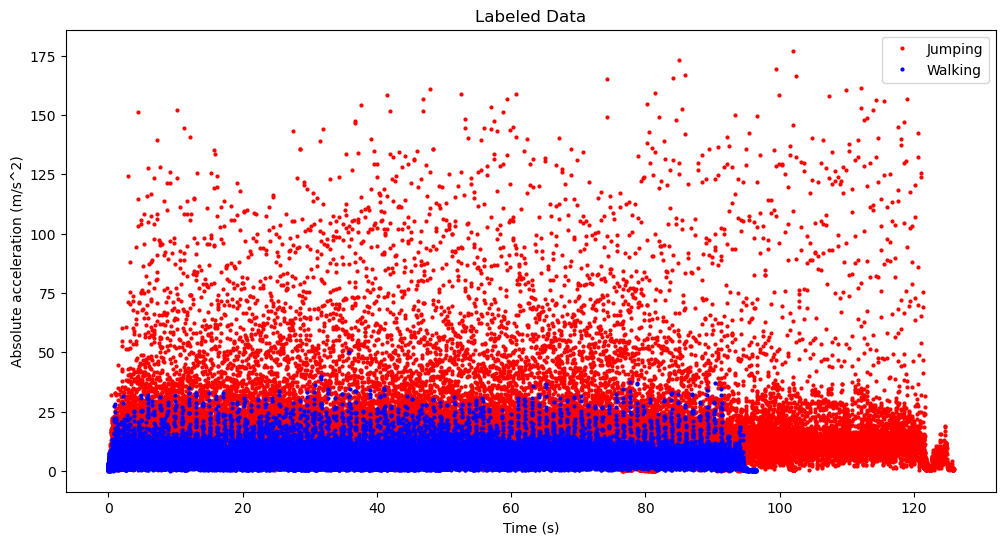

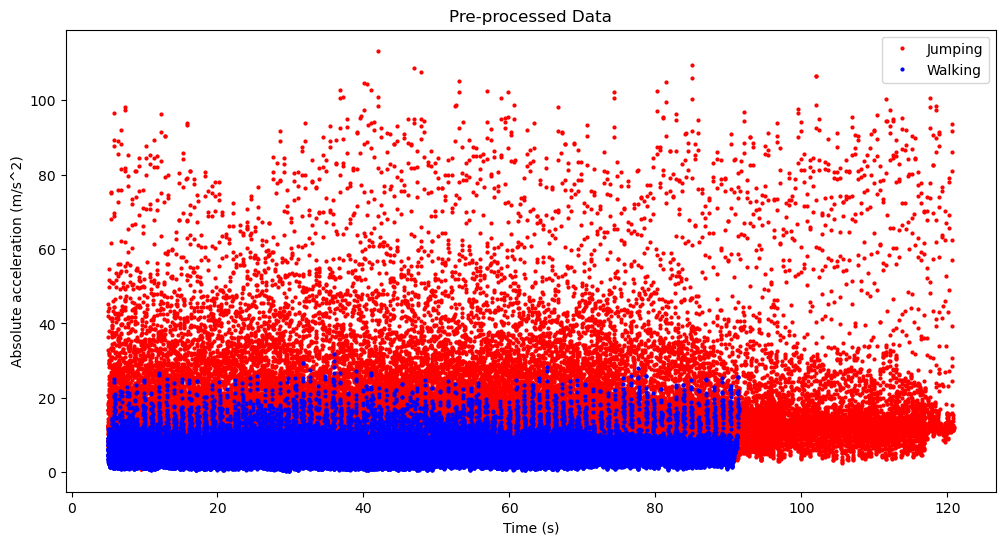

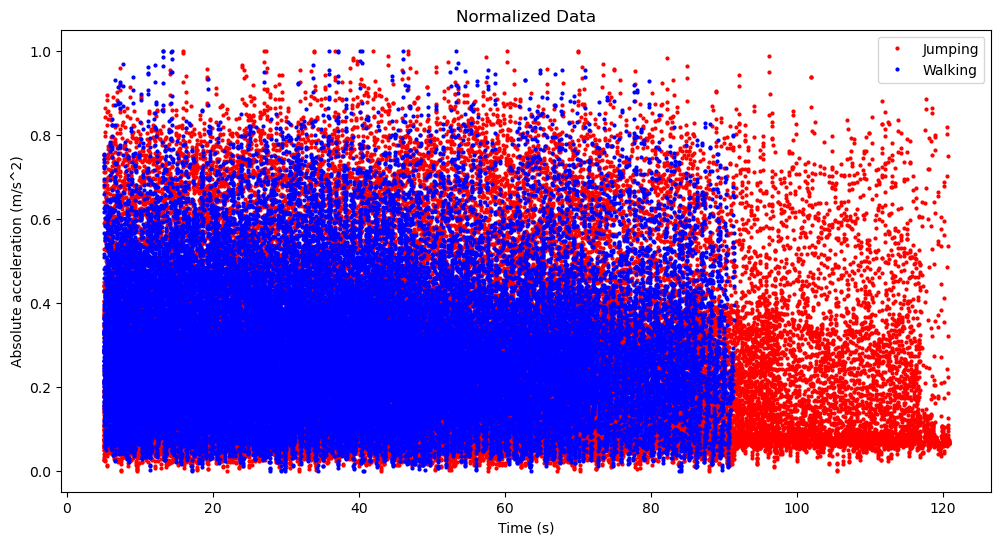

In [295]:
activity_colors = {0: 'red', 1: 'blue'}
activity_labels = {0: 'Jumping', 1: 'Walking'}

# Plot labeled_data
labeled_data_concat = pd.concat(labeled_data)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = labeled_data_concat[labeled_data_concat['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Labeled Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()

# Plot pre_processed_data
preprocessed_data_concat = pd.concat(preprocessed_data)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = preprocessed_data_concat[preprocessed_data_concat['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Pre-processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()

# Plot normalized_data
normalized_data_concat = pd.concat(normalized_data)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = normalized_data_concat[normalized_data_concat['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Normalized Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()


In [296]:
len(labeled_data)

16

In [297]:
normalized_data

[       Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
 504    5.025136                       0.473813                       0.671535   
 505    5.035151                       0.513865                       0.639281   
 506    5.045165                       0.559841                       0.583827   
 507    5.055180                       0.604381                       0.527395   
 508    5.065195                       0.643781                       0.474020   
 ...         ...                            ...                            ...   
 7640  76.489862                       0.680924                       0.150193   
 7641  76.499877                       0.683288                       0.128002   
 7642  76.509891                       0.689579                       0.108200   
 7643  76.519906                       0.702008                       0.095570   
 7644  76.529921                       0.719776                       0.092791   
 
       Linear 

# Segmenting and Labelling

In [298]:
# Segmenting and Labelling
segmented_data = []
for data in normalized_data:
    segmented_data.extend(segment_data(data))

# Prepare data and labels
data_matrix = []
label_vector = []

for segment in segmented_data:
    data_matrix.append(extract_features(segment))
    label = segment.iloc[0, -1]
    label_vector.append(label)



In [299]:
pd.DataFrame(data_matrix).shape

(236, 12)

In [301]:
pd.DataFrame(label_vector)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
231,1.0
232,1.0
233,1.0
234,1.0


# Classification & Dimensionality Reduction

Accuracy: 0.75
Recall: 0.7142857142857143


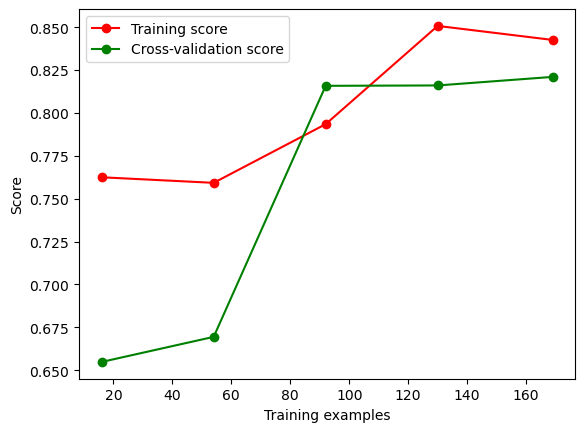

In [302]:
#%%
#Split the data into a training set (90%) and a testing set (10%)
X_train, X_test, Y_train, Y_test = train_test_split(data_matrix, label_vector, test_size=0.1, random_state=42, shuffle = True)

#Create a pipeline with PCA and logistic regression
pipe = make_pipeline(PCA(n_components=2), LogisticRegression())

#Train the logistic regression model
pipe.fit(X_train, Y_train)

#Apply the trained model on the test set and record the accuracy
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

recall = recall_score(Y_test, y_pred, average='macro')
print(f"Recall: {recall}")

#Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, Y_train, cv=5, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Accuracy: 0.8333333333333334
Recall: 0.8285714285714285


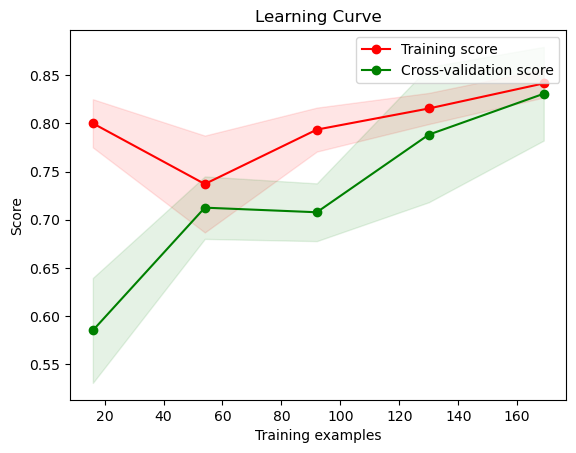

In [303]:
#Split the data into training and testing sets with 90% training and 10% testing
X_train, X_test, Y_train, Y_test = train_test_split(data_matrix, label_vector, test_size=0.1, random_state=42, stratify=label_vector)

#Create a logistic regression model with regularization
log_reg = LogisticRegression(max_iter=10000, penalty='l2')

#Create a pipeline for the PCA and logistic regression
pipeline = make_pipeline(PCA(n_components=2), log_reg)

#Train the model
pipeline.fit(X_train, Y_train)

#Apply the trained model on the test set and record the accuracy
y_pred = pipeline.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {acc}")

recall = recall_score(Y_test, y_pred, average='macro')
print(f"Recall: {recall}")



#Calculate and plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, Y_train, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

In [304]:
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[12  2]
 [ 2  8]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
         1.0       0.80      0.80      0.80        10

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



In [305]:
#output model into a pickle file
pickle.dump(pipeline, open("model.pkl", "wb"))


In [306]:
with open("model.pkl", "wb") as f:
    pickle.dump(pipeline, f)
